In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [383]:
arr = np.array([[1, 2, 3], [4, 5, 6]])

In [384]:
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [385]:
my_percen = np.nanpercentile(arr, 99, axis=1, keepdims=True)

In [386]:
my_percen

array([[2.98],
       [5.98]])

In [387]:
my_data_thresh = arr > my_percen

In [388]:
my_data_thresh

array([[False, False,  True],
       [False, False,  True]])

In [389]:
my_data_thresh = my_data_thresh.astype(int)

In [390]:
my_data_thresh

array([[0, 0, 1],
       [0, 0, 1]])

In [257]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=4, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [249]:

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]

f_m = jac_exp.matrix.toarray()

np.fill_diagonal(f_m, 0)

df_exp_corr = pd.DataFrame(f_m ,  index=all_genes, columns = all_genes)

In [362]:
df_exp_corr

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         0.000000         0.343890         0.487717   
ENSG00000233750         0.343890         0.000000         0.860658   
ENSG00000268903         0.487717         0.860658         0.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000155959         0.276849         0.040029         0.130469   
ENSG00000155961         0.128407         0.128214         0.097678   
ENSG00000155962         0.073441         0.152424         0.278535   
ENSG00000224533         0.334817         0.349970         0.296989   
ENSG00000185973         0.401233         0.185124         0.287707   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         0.000000         0.833857         0.110389   
ENSG00000241860         0.833857         0.000000         0.083856   
...                          ...              ...              ...   
ENSG00000155959         0.077081         0.316597         0.176820   
ENSG00000155961         0.141587         0.323042         0.130175   
ENSG00000155962         0.298601         0.382400         0.077759   
ENSG00000224533         0.386713         0.498483         0.235486   
ENSG00000185973         0.322068         0.724452         0.291270   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000155959         0.678122         0.712112         0.395085   
ENSG00000155961         0.521158         0.579213         0.386790   
ENSG00000155962         0.585610         0.620367         0.564975   
ENSG00000224533         0.667091         0.538497         0.702738   
ENSG00000185973         0.626955         0.728197         0.779498   

                 ENSG00000225972  ...  ENSG00000185010  ENSG00000277203  \
ENSG00000278267         0.208983  ...         0.164307         0.385439   
ENSG00000233750         0.018238  ...         0.036482         0.231122   
ENSG00000268903         0.194718  ...         0.150049         0.649567   
ENSG00000269981         0.067739  ...         0.280591         0.514719   
ENSG00000241860         0.002976  ...         0.433731         0.334044   
...                          ...  ...              ...              ...   
ENSG00000155959         0.093009  ...         0.932798         0.870960   
ENSG00000155961         0.009413  ...         0.772858         0.644082   
ENSG00000155962         0.093091  ...         0.919599         0.646647   
ENSG00000224533         0.010708  ...         0.564739         0.443018   
ENSG00000185973         0.023739  ...         0.924385         0.664635   

                 ENSG00000165775  ENSG00000214827  ENSG00000185515  \
ENSG00000278267         0.298960         0.589250         0.373065   
ENSG00000233750         0.019885         0.179310         0.108605   
ENSG00000268903         0.146318         0.243782         0.220238   
ENSG00000269981         0.059280         0.163406         0.248240   
ENSG00000241860         0.145356         0.526769         0.550166   
...                          ...              ...              ...   
ENSG00000155959         0.999166         0.911992         0.999719   
ENSG00000155961         0.740986 

In [250]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_exp_corr_pdist = sp.distance.squareform(df_exp_corr)

In [251]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(df_exp_corr_pdist, method='average')

In [63]:
temp.max()

48483.0

In [252]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(temp,0.1,criterion='distance')

In [302]:
len(list(np.unique(fl)))

16419

In [244]:
len(fl)

24243

In [235]:
from collections import Counter
z = list(fl)
z = Counter(z)

In [231]:
max(z.values())

19

In [260]:
z.values()

dict_values([1120, 2, 3, 4, 5, 1, 1, 2, 6, 12, 7, 7, 4, 1, 1, 1, 1, 1, 1, 2, 7, 2, 1, 1, 4, 6, 4, 2, 2, 2, 2, 3, 1, 5, 3, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 3, 4, 2, 1, 3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 5, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 4, 10, 4, 3, 2, 1, 3, 1, 1, 2, 1, 6, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 3, 1, 1, 2, 2, 6, 4, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 6, 1, 1, 2, 5, 2, 1, 8, 4, 2, 1, 1, 2, 1, 2, 12, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 5, 1, 4, 1, 2, 2, 2, 2, 4, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 4, 3, 1, 2, 1, 1, 3, 3, 1, 2, 2, 8, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 6, 3, 1, 2, 1, 1, 1, 2, 7, 5, 8, 3, 3, 1, 1, 1, 8, 1, 1, 4, 2, 1, 1, 1, 4, 4, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 3, 6, 14, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 7, 3, 2, 1, 2, 2, 1, 5, 2, 1, 1, 2, 1, 1, 6, 5, 1, 7, 2, 3, 1, 2, 1, 1, 2, 1, 1, 2, 2, 3,

In [290]:
z.keys()

dict_keys([9198, 8579, 8669, 8135, 8932, 649, 7927, 4560, 9072, 9173, 9025, 8966, 8605, 2120, 273, 4001, 3660, 11088, 9389, 8190, 9090, 5705, 12980, 1017, 8702, 8654, 8749, 6938, 6210, 5479, 8346, 8625, 1271, 8657, 7635, 8323, 39, 1509, 7308, 6920, 13560, 3111, 1982, 135, 769, 15010, 11051, 4482, 6417, 9631, 759, 4376, 15804, 13854, 11121, 10430, 5987, 8099, 8209, 5839, 299, 8960, 433, 7245, 13765, 3074, 5536, 10263, 625, 7188, 13115, 13467, 1573, 1131, 9977, 3762, 9566, 2032, 12033, 5544, 8070, 9054, 8642, 7053, 1231, 7019, 2799, 43, 10967, 13998, 9404, 7920, 15697, 11771, 8517, 9140, 7946, 8647, 5742, 2441, 8188, 10817, 15603, 4405, 15468, 9109, 14653, 9403, 16246, 14179, 15218, 7799, 4291, 14030, 1944, 5809, 10395, 8047, 913, 12671, 5992, 4943, 8959, 8979, 927, 1397, 16033, 6150, 5857, 14341, 2490, 13074, 12887, 15154, 6237, 12849, 10768, 2156, 10701, 6691, 8367, 10272, 5963, 2583, 9161, 3409, 12519, 4343, 8621, 7193, 3668, 9191, 9057, 6565, 9269, 4016, 8196, 12537, 5163, 9186, 7136

In [301]:
len([x for x in z.values() if x > 5])

205

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 50.0)

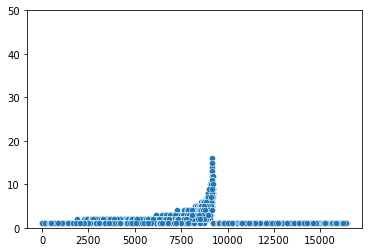

In [237]:
ax = sns.scatterplot(z.keys(), z.values())

ax.set_ylim([0,50])

(0.0, 100.0)

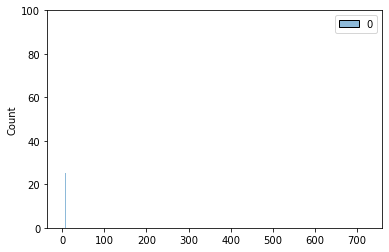

In [204]:
ax = sns.histplot(z.values(), bins=16745)
ax.set_ylim([0,100])

In [253]:
len(all_genes)

24243

In [291]:
df_exp_clust = pd.DataFrame(fl ,  index=all_genes)

df_exp_clust['label'] = df_exp_clust[0]

for clust, clust_len in zip(z.keys(), z.values()):
    if clust_len >= 5:
        
        print (clust, clust_len)
        df_exp_clust[clust] = [1 if x == clust else 0 for x in df_exp_clust['label'].tolist()]

9198 1120
8932 5
9072 6
9173 12
9025 7
8966 7
9090 7
8654 6
8657 5
9054 5
8642 5
9140 10
9109 6
8959 6
9161 6
8621 5
9191 8
9186 12
8690 5
9101 8
9124 6
9053 7
9029 5
9189 8
8934 8
9117 6
9183 14
9135 7
8781 5
8782 6
9115 5
9175 7
9108 8
8739 5
8889 7
9080 10
8940 6
9164 10
9193 9
8921 5
9088 8
9111 8
8962 5
8742 5
8867 5
9170 7
8818 6
8602 5
9182 15
9084 7
8729 5
8638 6
8999 5
8588 6
9157 8
9074 5
8926 7
8846 5
9093 8
8845 5
8609 5
8885 5
8923 6
8929 7
8759 5
8856 6
8890 6
9136 9
9128 10
8994 6
8826 5
9032 5
9129 7
8601 5
9012 8
8744 5
8250 5
9138 10
8834 6
8751 5
8583 5
8803 5
9036 8
9002 6
8410 5
9060 6
9081 8
9148 10
9079 6
9014 6
9176 8
8754 5
9038 6
9065 5
9139 7
8965 6
9113 5
8808 6
9187 10
8789 6
8844 5
8476 5
9194 12
9163 10
8992 6
8763 5
9159 7
9167 11
8635 5
9110 7
9154 6
8441 5
9190 8
9126 7
9027 6
9184 12
9073 7
9063 7
8988 5
9146 5
8745 6
9162 7
9147 6
8735 5
9178 16
9106 5
8501 5
9174 12
9122 8
9017 7
9042 6
9156 7
9102 8
9097 6
8930 5
9172 8
9131 6
8791 6
8428 5
9001 6


In [294]:
df_exp_clust = df_exp_clust.drop(['label', 0], axis=1)

In [304]:
resolution_human = 1000
species = "human"
SRP_name = "aggregates"
resolution = "1kbp_raw"

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr_cre/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'

jac_exp = hm.hiCMatrix(exp_file_path)

all_genes = [x[3].decode() for x in jac_exp.cut_intervals]

f_m = jac_exp.matrix.toarray()
f_m = f_m + abs(f_m.min())

df_hic_corr = pd.DataFrame(f_m,  index=all_genes, columns = all_genes)




In [303]:
l

NameError: name 'l' is not defined

In [289]:
df_exp_clust[12076].sum()

1

In [351]:
from scipy.sparse import coo_matrix
import h5py
import logging
import numpy as np
import pandas as pd

def parse_go_hd5(filename):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        df = pd.DataFrame(coo.toarray(),  index=columns, columns = row )
        duplicates = df.index.duplicated(keep='first')
        df = df.loc[~duplicates, :]
    return df

def parse_expression_hd5_lee(filename):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                row_uid.append(x_o)
            except KeyError:
                counter = counter + 1
                row_uid.append('del')
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    duplicates = df.index.duplicated(keep='first')
    df = df.loc[~duplicates, ~duplicates]


    return df 

In [352]:
go_df = parse_go_hd5("/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_gene2go.hdf5")

In [370]:
exp_genes = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/Homo_sapiens_average_rank.csv")

exp_genes['genes'] = [x.split('.')[0] for x in exp_genes['genes']]

exp_genes.set_index('genes', inplace=True)

exp_genes['avg_rank'] = exp_genes.sum(axis=1)

exp_genes['avg_rank'] = [ x/ exp_genes.shape[1] for x in  exp_genes['avg_rank']]

exp_genes = exp_genes[['avg_rank']]

exp_genes.reset_index(inplace=True)

exp_genes.drop_duplicates(['genes'], inplace=True)

In [373]:
high_auc_gene = exp_genes[exp_genes['avg_rank'] > 0.7]['genes'].tolist()

In [374]:
go_df_sel = go_df[go_df.index.isin(high_auc_gene)]

In [391]:
df_2d_jac, go_chrom  = run_egad(go_df, df_hic_corr)

(15058, 15058)
(15058, 22517)
0.9952744607425875
0.0


<ipython-input-257-d67740303d7e>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [393]:
df_t = df_2d_jac.merge(go_df.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')


In [397]:
df_t['decile'] = pd.qcut(df_t[0] , 10, labels=np.arange(10, 0, -1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='decile', ylabel='AUC'>

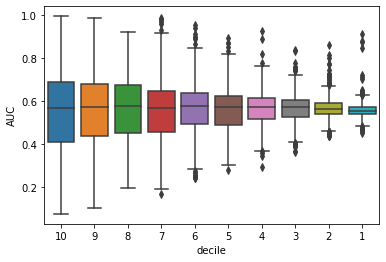

In [398]:
sns.boxplot(df_t['decile'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='decile', ylabel='0'>

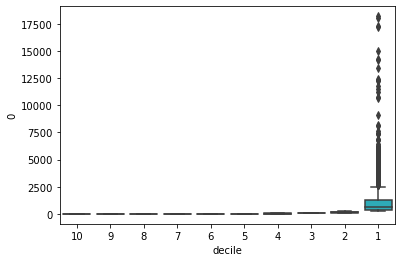

In [399]:
sns.boxplot(df_t['decile'], df_t[0])

In [379]:
df_2d_jac, go_chrom  = run_egad(go_df_sel, df_hic_corr)

(11414, 11414)
(11414, 22517)
0.9950893867008677
0.0


<ipython-input-257-d67740303d7e>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


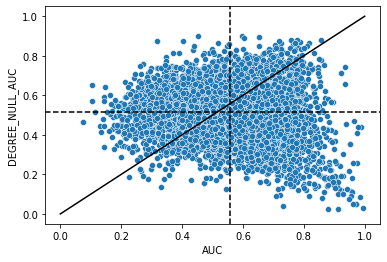

In [396]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


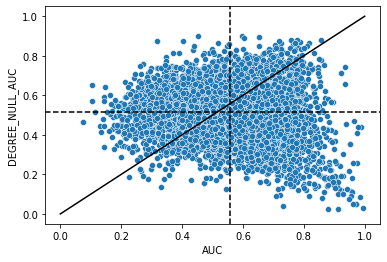

In [354]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


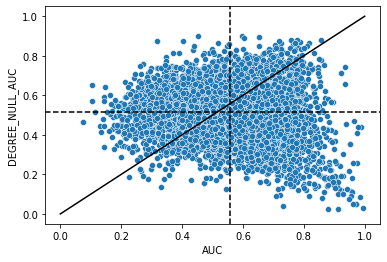

In [392]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

<AxesSubplot:xlabel='AUC', ylabel='Count'>

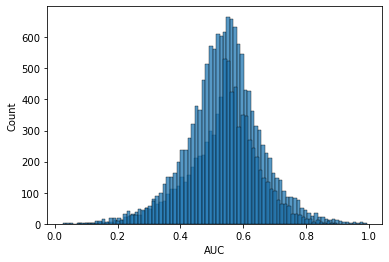

In [360]:
sns.histplot(df_2d_jac['AUC'])
sns.histplot(df_2d_jac['DEGREE_NULL_AUC'])

<AxesSubplot:xlabel='AUC', ylabel='Count'>

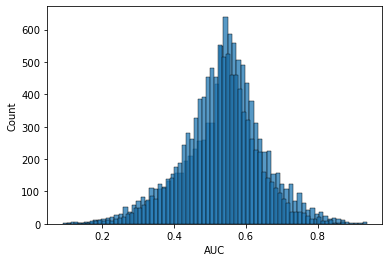

In [381]:
sns.histplot(df_2d_jac['AUC'])
sns.histplot(df_2d_jac['DEGREE_NULL_AUC'])

In [358]:
df_2d_jac['DEGREE_NULL_AUC'].mean()

0.5149766898724275

In [305]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_hic_corr)

(23465, 23465)
(23465, 329)
0.9995937815941353
3.632359968364085e-09


<ipython-input-257-d67740303d7e>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [363]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_exp_corr)

(24243, 24243)
(24243, 329)
0.9995935278907947
4.124902033575406e-05


<ipython-input-257-d67740303d7e>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


In [365]:
df_exp_clust

9198  8932  9072  9173  9025  8966  9090  8654  8657  9054  \
ENSG00000278267     1     0     0     0     0     0     0     0     0     0   
ENSG00000233750     0     0     0     0     0     0     0     0     0     0   
ENSG00000268903     0     0     0     0     0     0     0     0     0     0   
ENSG00000269981     1     0     0     0     0     0     0     0     0     0   
ENSG00000241860     0     0     0     0     0     0     0     0     0     0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959     0     0     0     0     0     0     0     0     0     0   
ENSG00000155961     0     0     0     0     0     0     0     0     0     0   
ENSG00000155962     0     0     0     0     0     0     0     0     0     0   
ENSG00000224533     0     0     0     0     0     0     0     0     0     0   
ENSG00000185973     0     0     0     0     0     0     0     0     0     0   

                 ...  8881  8762  8903  9095  8630  8968  8544  8548  8851  \
ENSG00000278267  ...     0     0     0     0     0     0     0     0     0   
ENSG00000233750  ...     0     0     0     0     0     0     0     0     0   
ENSG00000268903  ...     0     0     0     0     0     0     0     0     0   
ENSG00000269981  ...     0     0     0     0     0     0     0     0     0   
ENSG00000241860  ...     0     0     0     0     0     0     0     0     0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155961  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155962  ...     0     0     0     0     0     0     0     0     0   
ENSG00000224533  ...     0     0     0     0     0     0     0     0     0   
ENSG00000185973  ...     0     0     0     0     0     0     0     0     0   

                 8721  
ENSG00000278267     0  
ENSG00000233750     0  
ENSG00000268903     0  
ENSG00000269981     0  
ENSG00000241860     0  
...               ...  
ENSG00000155959     0  
ENSG00000155961     0  
ENSG00000155962     0  
ENSG00000224533     0  
ENSG00000185973     0  

[24243 rows x 329 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


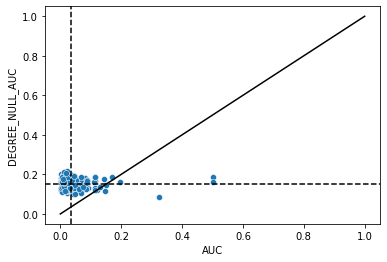

In [364]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [361]:
df_exp_clust

9198  8932  9072  9173  9025  8966  9090  8654  8657  9054  \
ENSG00000278267     1     0     0     0     0     0     0     0     0     0   
ENSG00000233750     0     0     0     0     0     0     0     0     0     0   
ENSG00000268903     0     0     0     0     0     0     0     0     0     0   
ENSG00000269981     1     0     0     0     0     0     0     0     0     0   
ENSG00000241860     0     0     0     0     0     0     0     0     0     0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959     0     0     0     0     0     0     0     0     0     0   
ENSG00000155961     0     0     0     0     0     0     0     0     0     0   
ENSG00000155962     0     0     0     0     0     0     0     0     0     0   
ENSG00000224533     0     0     0     0     0     0     0     0     0     0   
ENSG00000185973     0     0     0     0     0     0     0     0     0     0   

                 ...  8881  8762  8903  9095  8630  8968  8544  8548  8851  \
ENSG00000278267  ...     0     0     0     0     0     0     0     0     0   
ENSG00000233750  ...     0     0     0     0     0     0     0     0     0   
ENSG00000268903  ...     0     0     0     0     0     0     0     0     0   
ENSG00000269981  ...     0     0     0     0     0     0     0     0     0   
ENSG00000241860  ...     0     0     0     0     0     0     0     0     0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155961  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155962  ...     0     0     0     0     0     0     0     0     0   
ENSG00000224533  ...     0     0     0     0     0     0     0     0     0   
ENSG00000185973  ...     0     0     0     0     0     0     0     0     0   

                 8721  
ENSG00000278267     0  
ENSG00000233750     0  
ENSG00000268903     0  
ENSG00000269981     0  
ENSG00000241860     0  
...               ...  
ENSG00000155959     0  
ENSG00000155961     0  
ENSG00000155962     0  
ENSG00000224533     0  
ENSG00000185973     0  

[24243 rows x 329 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


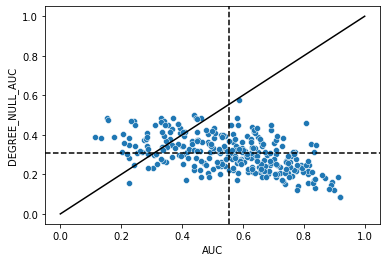

In [306]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


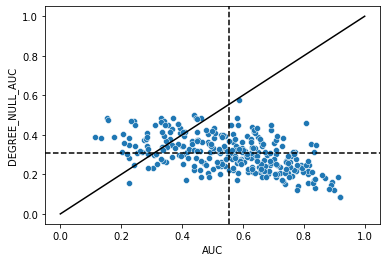

In [308]:
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

9198  8932  9072  9173  9025  8966  9090  8654  8657  9054  \
ENSG00000278267     1     0     0     0     0     0     0     0     0     0   
ENSG00000233750     0     0     0     0     0     0     0     0     0     0   
ENSG00000268903     0     0     0     0     0     0     0     0     0     0   
ENSG00000269981     1     0     0     0     0     0     0     0     0     0   
ENSG00000241860     0     0     0     0     0     0     0     0     0     0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959     0     0     0     0     0     0     0     0     0     0   
ENSG00000155961     0     0     0     0     0     0     0     0     0     0   
ENSG00000155962     0     0     0     0     0     0     0     0     0     0   
ENSG00000224533     0     0     0     0     0     0     0     0     0     0   
ENSG00000185973     0     0     0     0     0     0     0     0     0     0   

                 ...  8881  8762  8903  9095  8630  8968  8544  8548  8851  \
ENSG00000278267  ...     0     0     0     0     0     0     0     0     0   
ENSG00000233750  ...     0     0     0     0     0     0     0     0     0   
ENSG00000268903  ...     0     0     0     0     0     0     0     0     0   
ENSG00000269981  ...     0     0     0     0     0     0     0     0     0   
ENSG00000241860  ...     0     0     0     0     0     0     0     0     0   
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
ENSG00000155959  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155961  ...     0     0     0     0     0     0     0     0     0   
ENSG00000155962  ...     0     0     0     0     0     0     0     0     0   
ENSG00000224533  ...     0     0     0     0     0     0     0     0     0   
ENSG00000185973  ...     0     0     0     0     0     0     0     0     0   

                 8721  
ENSG00000278267     0  
ENSG00000233750     0  
ENSG00000268903     0  
ENSG00000269981     0  
ENSG00000241860     0  
...               ...  
ENSG00000155959     0  
ENSG00000155961     0  
ENSG00000155962     0  
ENSG00000224533     0  
ENSG00000185973     0  

[24243 rows x 329 columns]

In [346]:
df_t = df_t[df_t[0]<=200]

In [342]:
df_t

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value index  0
1    0.579152      1255.736856         0.170009  0.302519  8932  5
2    0.391648      2199.940190         0.410006  0.198003  9072  6
4    0.563350      1717.710811         0.276689  0.132789  9025  7
5    0.650475      2206.153204         0.390704  0.024413  8966  7
6    0.781910      1119.391168         0.139453  0.025125  9090  7
..        ...              ...              ...       ...   ... ..
302  0.664550      1993.558635         0.354723  0.115730  8903  5
303  0.396813      1761.524404         0.292882  0.058612  9095  5
304  0.448830      2440.202915         0.479122  0.173616  8630  5
305  0.882431      1037.006584         0.124365  0.001935  8548  5
306  0.478865      2290.992186         0.422822  0.200986  8721  5

[290 rows x 6 columns]

In [366]:
df_t = df_2d_jac.merge(df_exp_clust.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')

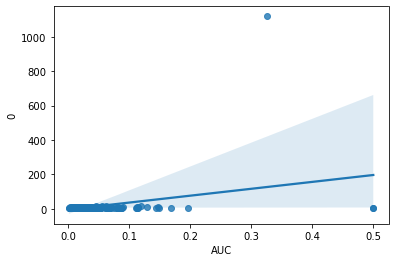

In [368]:
ax = sns.regplot(x=df_t['AUC'], y=df_t[0])
#ax.set_xlim([0,20])
#ax.set_ylim([0,20])

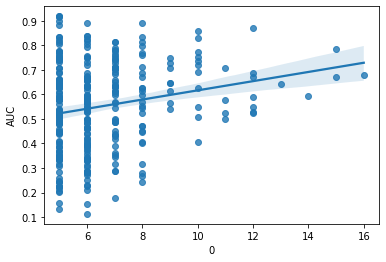

In [350]:
ax = sns.regplot(y=df_t['AUC'], x=df_t[0])
#ax.set_xlim([0,20])
#ax.set_ylim([0,20])

In [348]:
df_t['quintile'] = pd.qcut(df_t['AUC'] , 5, labels=np.arange(5, 0, -1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 20.0)

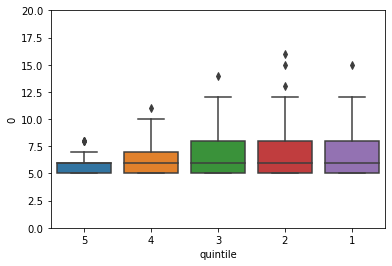

In [349]:
ax = sns.boxplot(df_t['quintile'], df_t[0])
ax.set_ylim([0,20])

(0.0, 5.0)

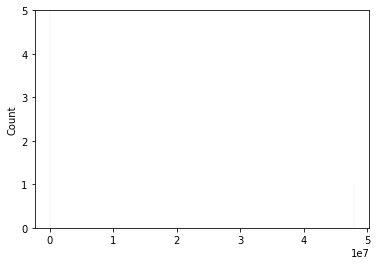

In [141]:
ax = sns.histplot(df_exp_clust.sum(), bins=800)
ax.set_ylim([0,5])

In [145]:
df_exp_clust.sum()[df_exp_clust.sum() > 2]

label    47930147
1034        15748
dtype: int64

In [ ]:
pd.pivot_table(df, values='D', index=['A', 'B'],
                       columns=['C'], aggfunc=np.sum)

In [ ]:
df_exp_corr = pd.DataFrame(f_m ,  index=all_genes, columns = all_genes)

In [49]:
import numpy as np
from scipy.cluster import hierarchy as hc
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt

In [50]:
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=0.5)

RecursionError: maximum recursion depth exceeded while getting the str of an object

In [11]:
import numpy as np 
from sklearn.cluster import AgglomerativeClustering

X = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])

#cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete') 
#cluster = AgglomerativeClustering(affinity='precomputed', linkage='average')
cluster = AgglomerativeClustering(affinity='precomputed', linkage='single')
cluster.fit(X)

AgglomerativeClustering(affinity='precomputed', linkage='single')

array([0.3, 0.4, 0.7])

In [13]:
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

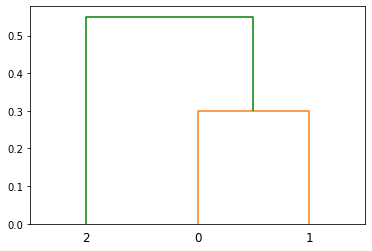

In [33]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(sp.distance.squareform(x), method='average')
plt.figure()
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=0.5)

In [36]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(temp,0.5,criterion='distance')

In [37]:
fl

array([1, 1, 2], dtype=int32)

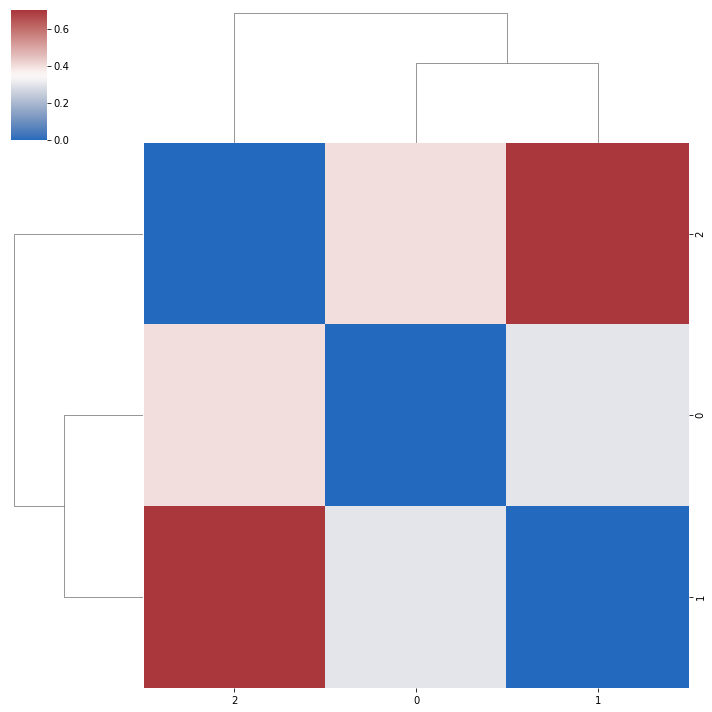

In [25]:
sns.clustermap(x, row_linkage=linkage, col_linkage=linkage, cmap="vlag")

In [20]:
temp

array([[0.  , 1.  , 0.3 , 2.  ],
       [2.  , 3.  , 0.55, 3.  ]])

In [ ]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(x, method='average')
plt.figure()
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=.7)

In [17]:
temp

array([[0.        , 1.        , 0.51961524, 2.        ],
       [2.        , 3.        , 0.84390388, 3.        ]])

In [6]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])

In [7]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [8]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [9]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5'

jac_exp = hm.hiCMatrix(exp_file_path)

all_genes = [x[3].decode() for x in jac_exp.cut_intervals]

df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)
    


KeyError: "Unable to open object (object 'matrix' doesn't exist)"